# TODO:

*   Store data in DICTIONARY to save and load easier
*   Pass tokenizer as function parameter (instead of calling global)




# Setup

In [57]:
!pip install -q tf-models-official==2.3.0
!pip install transformers

In [58]:
import os
import json, pickle

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split

import transformers
from transformers import BertTokenizer, TFBertModel
transformers.logging.set_verbosity_error() # suppress tokenizer sentences' length warnings so to not disturbate rou beautiful loading bar oh my gosh

from keras import Model
from keras.utils import plot_model
from keras.layers import Input, Dense

from google.colab import drive, files

In [59]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
try:
  with open('training_set.json') as f:
    json_data = json.load(f)
except:
  with open('/content/drive/My Drive/SQUAD/training_set.json') as f:
    json_data = json.load(f)

# Hyperparameters


In [61]:
### PARAMETERS ###
RANDOM_STATE = 42

# Dataset creation
SEQUENCE_LIMIT = 512
STRIDE = 256

TRAIN_LIMIT = 3000
VAL_LIMIT = 1000
TEST_LIMIT = 1000

# Model Training
EPOCHS = 3
BATCH_SIZE = 32

# <s> Dataset </s>

In [62]:
# Creates DataFrames with useful columns by unpacking 'paragraphs' column
def preprocess_df(df):
  temp = []
  title_dict = {}
  contexts = []

  for i, row in df.iterrows():
    for context in row['paragraphs']:
      contexts.append(context['context'])
      for qa in context['qas']:
        question_id = qa['id']
        question = qa['question']
        for answer in qa['answers']:
          answer_text = answer['text']
          answer_start = answer['answer_start']
          answer_end = answer_start+len(answer_text)
          temp.append([question_id, question, answer_text, answer_start, answer_end, i, len(contexts)-1])

  context_dict = dict(enumerate(contexts))
  df = pd.DataFrame(temp, columns=['question_id', 'question_text', 'answer_text', 'answer_start', 'answer_end', 'title_id', 'context_id'])
  
  return df, context_dict

# Read data from json
data = pd.json_normalize(json_data['data'])

# Split train and test
train_val, test = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)
train, val = train_test_split(train_val, test_size=0.25, random_state=RANDOM_STATE)

# Create DataFrames with useful columns
train_df, train_context_dict = preprocess_df(train)
val_df, val_context_dict = preprocess_df(val)
test_df, test_context_dict = preprocess_df(test)

train_df

,question_id,question_text,answer_text,answer_start,answer_end,title_id,context_id
0,5705e78f75f01819005e7734,Where does migration mainly occur?,the northern hemisphere,317,340,109,0
1,5705e78f75f01819005e7735,Why do birds primarily migrate?,availability of food,275,295,109,0
2,5705e78f75f01819005e7736,Which birds migrate?,Many species,127,139,109,0
3,5705e78f75f01819005e7737,What is bird migration?,"the regular seasonal movement, often north and...",18,125,109,0
4,5705e78f75f01819005e7738,What is a cause of death to birds during migra...,humans,240,246,109,0
...,...,...,...,...,...,...,...
49933,57314ace05b4da19006bcfe2,What quality has LEDs been used as?,medium-quality,30,44,417,10869
49934,57314ace05b4da19006bcfe3,What LED has the flattest I/V curve above the ...,Red,216,219,417,10869
49935,57314ace05b4da19006bcfe4,What LEDs have a very steep I/V curve?,Nitride-based LEDs,269,287,417,10869
49936,57314ace05b4da19006bcfe5,LED forward voltage is more current-dependent ...,Zener,418,423,417,10869


In [7]:
# Inspect data samples
def print_squad_sample(train_data, context_dict, line_length=120, separator_length=150):

  sample = train_data.sample(frac=1).head(1)
  context = context_dict[sample['context_id'].item()]

  print('='*separator_length, '\nCONTEXT:\n', '='*separator_length)

  lines = [''.join(context[idx:idx+line_length]) for idx in range(0, len(context), line_length)]
  for l in lines:
      print(l)

  print('='*separator_length, '\nQUESTION:', ' '*(3*separator_length//4), 'ANSWER:')

  questions = train_data[train_data['context_id'] == sample['context_id'].item()]

  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), answer)

print_squad_sample(train_df, train_context_dict)

CONTEXT:
Spielberg won the Academy Award for Best Director for Schindler's List (1993) and Saving Private Ryan (1998). Three of S
pielberg's films—Jaws (1975), E.T. the Extra-Terrestrial (1982), and Jurassic Park (1993)—achieved box office records, o
riginated and came to epitomize the blockbuster film. The unadjusted gross of all Spielberg-directed films exceeds $9 bi
llion worldwide, making him the highest-grossing director in history. His personal net worth is estimated to be more tha
n $3 billion. He has been associated with composer John Williams since 1974, who composed music for all save five of Spi
elberg's feature films.
QUESTION:                                                                                                                  ANSWER:
How much money has all of Steven Spielberg's movies grossed worldwide?                                                     exceeds $9 billion
What composer has Steven Spielberg been associated with since 1974?                      

# <s> Tokenizer </s>

In [63]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

print('[[CLS], [SEP]] = {}'.format(tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])))

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(train_df['question_text'][0])

# Print out the tokens.
print('\nTokenized sentence:')
print(tokenized_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indices.
print('\n{:<12} {:>6}\n'.format('TOKENS', 'INDICES'))
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6}'.format(tup[0], tup[1]))

[[CLS], [SEP]] = [101, 102]

Tokenized sentence:
['where', 'does', 'migration', 'mainly', 'occur', '?']

TOKENS       INDICES

where          2073
does           2515
migration      9230
mainly         3701
occur          5258
?              1029


In [9]:
# Returns start and end indices of sublist in list
def find_sublist(a, b):
  if len(a) == 0 or len(b) == 0:
    raise Exception("Lists with length 0")

  for i in range(len(a) - len(b) +1):
    if np.array_equal(a[i:i+len(b)], b):
      return i, i+len(b)-1

  return -1, -1

In [10]:
# Prints COOL progress bar (No, seriously, it's really cool!)
# REALLY DUDE, THIS STUFF IS GOLD
def print_progress(value, total, bar_width=100):
  perc = int(value/total*bar_width)
  rest = bar_width - perc
  print("\r{:>3} % [ {}{} ]".format(perc, perc*'■', rest*'─'), end="")

# ensure to preserve all sub-sequences of length limi-stride. 
def split_long_sequence(my_sequence, limit, stride):

  if len(my_sequence) <= limit: 
    return [my_sequence]
  
  rest = my_sequence
  split = []
  while len(rest) > limit:
    left_hand = rest[:limit]
    rest = rest[stride:]
    split.append(left_hand)
    
  split.append(rest)
  return split

In [11]:
def from_df_to_model_dict(df, context_dict, verbose=False):

  # initialize structures
  input_ids = []
  input_mask = []
  input_type_ids = []
  start_indexes = []
  end_indexes = []

  cut_counter = 0
  max_iter = len(df)
  new_entries = 0
  for i, row in df.iterrows():

    # print progress
    if (i+1) % (max_iter // 100) == 0 or i == 0:
      print_progress(i+1, max_iter)

    # encode question and context
    if verbose: print("\tTokenizing question and context...", end="")
    encoded_question = tokenizer.encode(row['question_text'])
    encoded_context = tokenizer.encode(context_dict[row['context_id']])[1:]

    # concatenate input data 
    if verbose: print("\tChecking sequence length...")
    if len(encoded_question + encoded_context) > SEQUENCE_LIMIT:
      # if the sequence is too long, split it in n subsequences of length <= SEQUENCE_LIMIT
      encoded_contexts = split_long_sequence(encoded_context,
                                             limit=SEQUENCE_LIMIT-len(encoded_question), 
                                             stride=STRIDE)
      cut_counter += 1
    else:
      encoded_contexts = [encoded_context]
    
    new_entries += len(encoded_contexts)-1
    # for each too long sequence, the context has been split in n parts. We need to process them separately, creating new entries for the input
    for context in encoded_contexts:
      
      encoded_input = encoded_question + context      

      # create mask of ones
      ones_mask = tf.ones_like(encoded_input)

      # add padding and convert to tensor
      if verbose: print("\tPadding...", end="")
      encoded_input = tf.keras.preprocessing.sequence.pad_sequences([encoded_input], maxlen=512, padding='pre')
      encoded_input = tf.squeeze(tf.convert_to_tensor(encoded_input))

      # processing answer indices
      if verbose: print("\tProcessing answer...", end="")
      tokenized_answer = tokenizer.encode(row['answer_text'])[1: -1]
      start_idx, end_idx = find_sublist(encoded_input, tokenized_answer)

      start_indexes.append(start_idx)
      end_indexes.append(end_idx)


      # create input_type_ids
      if verbose: print("\tInput types creation...", end="")
      type_ids = tf.concat([tf.zeros_like(encoded_question, dtype=tf.int32), 
                            tf.ones_like(encoded_context, dtype=tf.int32)], 
                          axis=-1)
      
      type_ids = tf.keras.preprocessing.sequence.pad_sequences([type_ids], maxlen=512, padding='pre')
      type_ids = tf.squeeze(tf.convert_to_tensor(type_ids))


      # create mask of zeros
      if verbose: print("\tMask creation...", end="")
      zeros_mask = tf.zeros(SEQUENCE_LIMIT - len(ones_mask), dtype=tf.int32)
      mask = tf.concat([zeros_mask, ones_mask], axis=-1)

      # append elements to lists
      if verbose: print("\tAppending inputs...", end="")
      input_ids.append(encoded_input)
      input_mask.append(mask)
      input_type_ids.append(type_ids)

  # save input data as dictionary
  inputs = {
    'input_ids': tf.convert_to_tensor(input_ids),
    'attention_mask': tf.convert_to_tensor(input_mask),
    'token_type_ids': tf.convert_to_tensor(input_type_ids)
    }

  assert len(input_ids) == len(df) + new_entries, f"ATTENTION:\nci sono {len(input_ids)} input_ids, MA {len(df)} righe nel df e {new_entries} nuove entries"
  return inputs, start_indexes, end_indexes

# Building Progress

In [ ]:
print("Building training set...")
train_inputs, train_starts_ids, train_ends_ids = from_df_to_model_dict(train_df, train_context_dict)

print("\n\nBuilding validation set...")
val_inputs, val_starts_ids, val_ends_ids = from_df_to_model_dict(val_df, val_context_dict)

print("\n\nBuilding test set...")
test_inputs, test_starts_ids, test_ends_ids = from_df_to_model_dict(test_df, test_context_dict)

Building training set...
 91 % [ ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■───────── ]

# Index to categorical


In [ ]:
# Replace -1 (answer not found) with 0
train_starts_ids = [val if val != -1 else 0 for val in train_starts_ids]
train_ends_ids = [val if val != -1 else 0 for val in train_ends_ids]

val_starts_ids = [val if val != -1 else 0 for val in val_starts_ids]
val_ends_ids = [val if val != -1 else 0 for val in val_ends_ids]

test_starts_ids = [val if val != -1 else 0 for val in test_starts_ids]
test_ends_ids = [val if val != -1 else 0 for val in test_ends_ids]

In [ ]:
# from ints to categorical
train_starts_cat = tf.keras.utils.to_categorical(train_starts_ids, num_classes=SEQUENCE_LIMIT)
train_ends_cat = tf.keras.utils.to_categorical(train_ends_ids, num_classes=SEQUENCE_LIMIT)

val_starts_cat = tf.keras.utils.to_categorical(val_starts_ids, num_classes=SEQUENCE_LIMIT)
val_ends_cat = tf.keras.utils.to_categorical(val_ends_ids, num_classes=SEQUENCE_LIMIT)

test_starts_cat = tf.keras.utils.to_categorical(test_starts_ids, num_classes=SEQUENCE_LIMIT)
test_ends_cat = tf.keras.utils.to_categorical(test_ends_ids, num_classes=SEQUENCE_LIMIT)

In [ ]:
# Inspect data
assert len(train_starts_ids) == len(train_ends_ids) == len(train_inputs['input_ids']) == len(train_inputs['attention_mask']) == len(train_inputs['token_type_ids'])
assert len(val_starts_ids) == len(val_ends_ids) == len(val_inputs['input_ids']) == len(val_inputs['attention_mask']) == len(val_inputs['token_type_ids'])
assert len(test_starts_ids) == len(test_ends_ids) == len(test_inputs['input_ids']) == len(test_inputs['attention_mask']) == len(test_inputs['token_type_ids'])

print("Shapes")
print("\nTrain starts:\t", train_starts_cat.shape)
print("Train ends:\t", train_ends_cat.shape)
print("\nVal starts:\t", val_starts_cat.shape)
print("Val ends:\t", val_ends_cat.shape)
print("\nTest starts:\t", test_starts_cat.shape)
print("Test ends:\t", test_ends_cat.shape)

# <s>  Save train and test inputs dataset <s>

In [ ]:
## TRAIN
with open("/content/drive/MyDrive/SQUAD/train_inputs.p", "wb") as f:
  pickle.dump(train_inputs, f)

with open("/content/drive/MyDrive/SQUAD/train_starts_ids.p", "wb") as f:
  pickle.dump(train_starts_ids, f)

with open("/content/drive/MyDrive/SQUAD/train_ends_ids.p", "wb") as f:
  pickle.dump(train_ends_ids, f)

with open("/content/drive/MyDrive/SQUAD/train_starts_cat.p", "wb") as f:
  pickle.dump(train_starts_cat, f)

with open("/content/drive/MyDrive/SQUAD/train_ends_cat.p", "wb") as f:
  pickle.dump(train_ends_cat, f)


## VALIDATION
with open("/content/drive/MyDrive/SQUAD/val_inputs.p", "wb") as f:
  pickle.dump(val_inputs, f)

with open("/content/drive/MyDrive/SQUAD/val_starts_ids.p", "wb") as f:
  pickle.dump(val_starts_ids, f)

with open("/content/drive/MyDrive/SQUAD/val_ends_ids.p", "wb") as f:
  pickle.dump(val_ends_ids, f)

with open("/content/drive/MyDrive/SQUAD/val_starts_cat.p", "wb") as f:
  pickle.dump(val_starts_cat, f)

with open("/content/drive/MyDrive/SQUAD/val_ends_cat.p", "wb") as f:
  pickle.dump(val_ends_cat, f)


## TEST
with open("/content/drive/MyDrive/SQUAD/test_inputs.p", "wb") as f:
  pickle.dump(test_inputs, f)

with open("/content/drive/MyDrive/SQUAD/test_starts_ids.p", "wb") as f:
  pickle.dump(test_starts_ids, f)

with open("/content/drive/MyDrive/SQUAD/test_ends_ids.p", "wb") as f:
  pickle.dump(test_ends_ids, f)

with open("/content/drive/MyDrive/SQUAD/test_starts_cat.p", "wb") as f:
  pickle.dump(test_starts_cat, f)

with open("/content/drive/MyDrive/SQUAD/test_ends_cat.p", "wb") as f:
  pickle.dump(test_ends_cat, f)

# Load train and test inputs datasets

In [ ]:
## TRAIN
with open("/content/drive/MyDrive/SQUAD/train_inputs.p", "rb") as f:
  train_inputs = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/train_starts_ids.p", "rb") as f:
  train_starts_ids = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/train_ends_ids.p", "rb") as f:
  train_ends_ids = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/train_starts_cat.p", "rb") as f:
  train_starts_cat = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/train_ends_cat.p", "rb") as f:
  train_ends_cat = pickle.load(f)


## VALIDATION
with open("/content/drive/MyDrive/SQUAD/val_inputs.p", "rb") as f:
  val_inputs = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/val_starts_ids.p", "rb") as f:
  val_starts_ids = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/val_ends_ids.p", "rb") as f:
  val_ends_ids = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/val_starts_cat.p", "rb") as f:
  val_starts_cat = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/val_ends_cat.p", "rb") as f:
  val_ends_cat = pickle.load(f)


## TEST
with open("/content/drive/MyDrive/SQUAD/test_inputs.p", "rb") as f:
  test_inputs = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/test_starts_ids.p", "rb") as f:
  test_starts_ids = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/test_ends_ids.p", "rb") as f:
  test_ends_ids = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/test_starts_cat.p", "rb") as f:
  test_starts_cat = pickle.load(f)

with open("/content/drive/MyDrive/SQUAD/test_ends_cat.p", "rb") as f:
  test_ends_cat = pickle.load(f)

# Build model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                

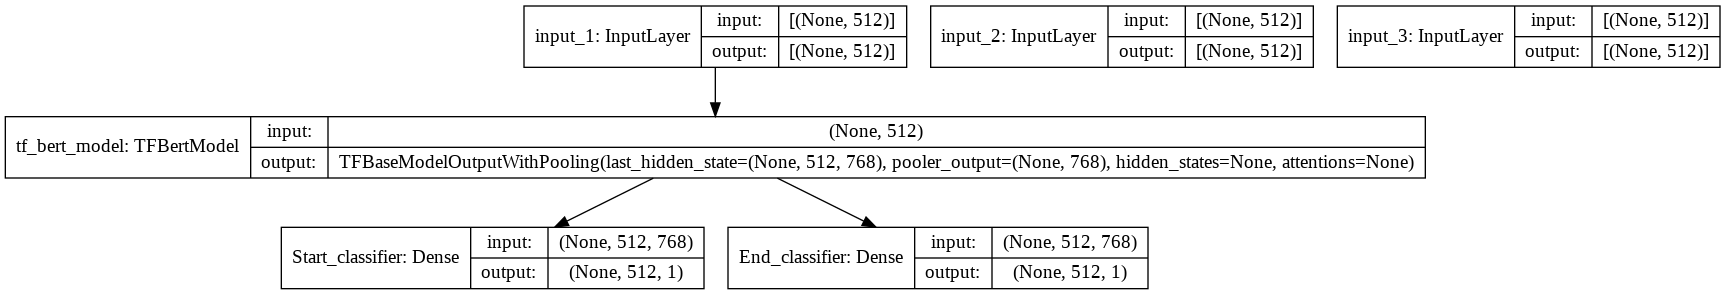

In [ ]:
@tf.autograph.experimental.do_not_convert
def build_model():

  # Define Input layers
  input_ids_layer = Input(shape = (512,), dtype='int64')
  attention_mask_layer = Input(shape = (512,), dtype='int64')
  token_ids_layer = Input(shape = (512,), dtype='int64')

  # Load Bert model
  bert_model = TFBertModel.from_pretrained('bert-base-uncased')
  
  # Set bert layers to not-trainable
  for layer in bert_model.layers:
    layer.trainable = False
  
  # Initialize bert model
  bert = bert_model(input_ids = input_ids_layer,
                    attention_mask = attention_mask_layer,
                    token_type_ids = token_ids_layer,
                    return_dict = False,
                    output_attentions = False,
                    output_hidden_states = False
                    ).last_hidden_state
  
  # Define output classifiers
  start_classifier = Dense(units=1, activation="softmax", name="Start_classifier")(bert)
  end_classifier = Dense(units=1, activation="softmax", name="End_classifier")(bert)

  # Build model
  model = Model(inputs=[input_ids_layer, attention_mask_layer, token_ids_layer], 
                outputs=[start_classifier, end_classifier])
  
  model.summary()
  return model

model = build_model()
plot_model(model, show_shapes=True)

In [ ]:
# Define model parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train

In [ ]:
# Fit model with train set
model_fit = model.fit(x = [train_inputs['input_ids'][:TRAIN_LIMIT],
                           train_inputs['attention_mask'][:TRAIN_LIMIT],
                           train_inputs['token_type_ids'][:TRAIN_LIMIT]],
                      y = [train_starts_cat, train_ends_cat,
                       
                      batch_size=BATCH_SIZE, epochs=EPOCHS, 
                      
                      validation_data=([val_inputs['input_ids'],
                                        val_inputs['attention_mask'],
                                        val_inputs['token_type_ids']], 
                                        [val_starts_cat, val_ends_cat]
                                       )
                      )

Epoch 1/3
188/188 [==============================] - 334s 2s/step - loss: 12.4767 - Start_classifier_loss: 6.2383 - End_classifier_loss: 6.2383 - Start_classifier_accuracy: 6.1021e-04 - End_classifier_accuracy: 6.1021e-04 - val_loss: 12.4767 - val_Start_classifier_loss: 6.2383 - val_End_classifier_loss: 6.2383 - val_Start_classifier_accuracy: 0.0080 - val_End_classifier_accuracy: 0.0080
Epoch 2/3
188/188 [==============================] - 323s 2s/step - loss: 12.4767 - Start_classifier_loss: 6.2383 - End_classifier_loss: 6.2383 - Start_classifier_accuracy: 8.9877e-04 - End_classifier_accuracy: 8.9877e-04 - val_loss: 12.4767 - val_Start_classifier_loss: 6.2383 - val_End_classifier_loss: 6.2383 - val_Start_classifier_accuracy: 0.0080 - val_End_classifier_accuracy: 0.0080
Epoch 3/3
188/188 [==============================] - 323s 2s/step - loss: 12.4767 - Start_classifier_loss: 6.2383 - End_classifier_loss: 6.2383 - Start_classifier_accuracy: 9.3847e-04 - End_classifier_accuracy: 9.3847e-0

# Test

In [ ]:
# Predict test set
start_pred, end_pred = model.predict([test_inputs["input_ids"], 
                                      test_inputs["attention_mask"], 
                                      test_inputs["token_type_ids"]])

# Predictions - categorical
start_pred_cat = np.argmax(start_pred, axis=-1)
end_pred_cat = np.argmax(end_pred, axis=-1)

# Predictions - indexes
start_pred_ids = np.argmax(start_pred_cat, axis=-1)
end_pred_ids = np.argmax(end_pred_cat, axis=-1)

In [ ]:
def get_text_from_token_ids(context, start_id, end_id):
  return tokenizer.decode(context[start_id:end_id])

boom_baby = 0
for i, row in test_df.iterrows():
  if i == TEST_LIMIT: break
  true_answer = row["answer_text"]
  predicted_answer = get_text_from_token_ids(test_inputs["input_ids"][i-1], start_pred_ids[i-1], end_pred_ids[i-1])

  if true_answer == predicted_answer:
    boom_baby += 1

  if i % 100 == 0:
    print("\n\nQuestion: \n", row["question_text"])
    print("Context: \n", test_context_dict[row["context_id"]])
    print("Answer text: \n", true_answer)
    print(f"Our answer: \n\tids {(start_pred_ids[i-1], end_pred_ids[i-1])}\n\ttext: {predicted_answer}")
    print("-"*50)



Question: 
 What is the largest populated city in Arizona?
Context: 
 Tucson (/ˈtuːsɒn/ /tuːˈsɒn/) is a city and the county seat of Pima County, Arizona, United States, and home to the University of Arizona. The 2010 United States Census put the population at 520,116, while the 2013 estimated population of the entire Tucson metropolitan statistical area (MSA) was 996,544. The Tucson MSA forms part of the larger Tucson-Nogales combined statistical area (CSA), with a total population of 980,263 as of the 2010 Census. Tucson is the second-largest populated city in Arizona behind Phoenix, both of which anchor the Arizona Sun Corridor. The city is  located 108 miles (174 km) southeast of Phoenix and 60 mi (97 km) north of the U.S.-Mexico border. Tucson is the 33rd largest city and the 59th largest metropolitan area in the United States. Roughly 150 Tucson companies are involved in the design and manufacture of optics and optoelectronics systems, earning Tucson the nickname Optics Valley.


In [ ]:
print(f"Total matches\t{boom_baby} / {TEST_LIMIT} \t({round(boom_baby / TEST_LIMIT, 3)*100} %)")

In [ ]:
with open("results_2101_start_pred.txt", "w") as f:
  f.write(start_pred)

with open("results_2101_end_pred.txt", "w") as f:
  f.write(end_pred)